In [41]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from graphviz import Digraph
from IPython.display import display

In [42]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, criterion="gini", max_depth=None, min_impurity_decrease=0.0):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)
        return self

    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape

        if len(y) == 0:
            return TreeNode(value=None)
        if len(set(y)) == 1:
            return TreeNode(value=y[0])
        if self.max_depth is not None and depth >= self.max_depth:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        best_feature, best_threshold, best_gain = None, None, -np.inf

        for feature in range(num_features):
            col = X[:, feature]

            if self._is_numeric(col):
                try:
                    col_float = col.astype(float)
                    thresholds = np.linspace(np.min(col_float), np.max(col_float), num=10)
                except ValueError:
                    continue 
            else:
                thresholds = np.unique(col)

            for threshold in thresholds:
                if self._is_numeric(col):
                    left_idx = col.astype(float) <= float(threshold)
                else:
                    left_idx = col == threshold

                right_idx = ~left_idx

                if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                    continue

                gain = self._information_gain(y, col, threshold)
                if gain > best_gain:
                    best_feature, best_threshold, best_gain = feature, threshold, gain

        if best_feature is None or best_gain < self.min_impurity_decrease:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        col = X[:, best_feature]
        if self._is_numeric(col):
            left_idx = col.astype(float) <= float(best_threshold)
        else:
            left_idx = col == best_threshold
        right_idx = ~left_idx

        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)

        return TreeNode(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _is_numeric(self, col):
        try:
            col.astype(float)
            return True
        except:
            return False

    def _impurity(self, y):
        if self.criterion == "gini":
            probs = np.bincount(y) / len(y)
            return 1 - np.sum(probs ** 2)
        elif self.criterion == "entropy":
            probs = np.bincount(y) / len(y)
            return -np.sum([p * np.log2(p) for p in probs if p > 0])
        elif self.criterion == "misclassification":
            return 1 - max(np.bincount(y) / len(y))
        else:
            raise ValueError("Invalid criterion")

    def _information_gain(self, y, X_column, threshold):
        parent_impurity = self._impurity(y)

        if self._is_numeric(X_column):
            left_mask = X_column.astype(float) <= float(threshold)
        else:
            left_mask = X_column == threshold

        right_mask = ~left_mask

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0

        left_impurity = self._impurity(y[left_mask])
        right_impurity = self._impurity(y[right_mask])
        child_impurity = (
            (np.sum(left_mask) * left_impurity + np.sum(right_mask) * right_impurity) / len(y)
        )

        return parent_impurity - child_impurity

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        val = x[node.feature]
        if self._is_numeric(np.array([val])):
            if float(val) <= float(node.threshold):
                return self._traverse_tree(x, node.left)
            else:
                return self._traverse_tree(x, node.right)
        else:
            if val == node.threshold:
                return self._traverse_tree(x, node.left)
            else:
                return self._traverse_tree(x, node.right)

    def get_params(self, deep=True):
        return {
            "criterion": self.criterion,
            "max_depth": self.max_depth,
            "min_impurity_decrease": self.min_impurity_decrease,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    

In [53]:
class RandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=10, max_depth=None, min_impurity_decrease=0.0, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease
        self.random_state = random_state
        self.trees = []
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        np.random.seed(self.random_state) 

        self.trees = []  
        for _ in range(self.n_trees):
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_impurity_decrease=self.min_impurity_decrease
            )
            bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample, y_sample = X[bootstrap_indices], y[bootstrap_indices]
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

        return self

    def predict(self, X):        
        predictions = np.array([tree.predict(X) for tree in self.trees])        
        majority_votes = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
        return majority_votes

    def get_params(self, deep=True):
        return {
            "n_trees": self.n_trees,
            "max_depth": self.max_depth,
            "min_impurity_decrease": self.min_impurity_decrease,
            "random_state": self.random_state
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [44]:
df = pd.read_csv("C:/Users/aknur/Downloads/secondary_data.csv", sep=";")
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [45]:
missing_counts = df.isnull().sum()
print("\nMissing values per column:\n", missing_counts)


Missing values per column:
 class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64


In [46]:
threshold = 0.8
missing_fraction = df.isnull().mean()
cols_to_drop = missing_fraction[missing_fraction > threshold].index.tolist()
df = df.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)

Dropped columns: ['stem-root', 'veil-type', 'veil-color', 'spore-print-color']


In [47]:
numerical_cols = ["cap-diameter", "stem-height", "stem-width"]
categorical_cols = df.columns.difference(numerical_cols + ["class"])

In [48]:
for col in categorical_cols:
    df[col] = df[col].fillna("missing")

In [49]:
missing_counts2 = df.isnull().sum()
print("\nMissing values per column:\n", missing_counts2)


Missing values per column:
 class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-surface            0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


In [50]:
df.dtypes

class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-surface             object
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season                   object
dtype: object

In [55]:
X = df.drop(columns="class").values
y = (df["class"] == 'p').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

trees = {
    "Gini": DecisionTree(criterion="gini", max_depth=5),
    "Entropy": DecisionTree(criterion="entropy", max_depth=5),
    "Misclassification": DecisionTree(criterion="misclassification", max_depth=5)
}


In [57]:
for name, tree in trees.items():
    tree.fit(X_train, y_train)
    
rf = RandomForest(n_trees=10, max_depth=5, min_impurity_decrease=0.0, random_state=42)
rf.fit(X_train, y_train)

RandomForest(max_depth=5, random_state=42)

In [58]:
def zero_one_loss(y_true, y_pred):
    return np.mean(y_true != y_pred)

def compute_accuracy(model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_acc = np.mean(train_preds == y_train)
    test_acc = np.mean(test_preds == y_test)
    overfitting_gap = train_acc - test_acc  
    
    train_loss = zero_one_loss(y_train, train_preds)
    test_loss = zero_one_loss(y_test, test_preds)
    
    return train_acc, test_acc, overfitting_gap, train_loss, test_loss

# Check overfitting for Decision Trees
print("\nChecking Overfitting:\n")
for name, tree in trees.items():
    train_acc, test_acc, gap, train_loss, test_loss = compute_accuracy(tree, X_train, y_train, X_test, y_test)
    print(f"{name} Tree - Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Overfitting Gap: {gap:.4f}, Training 0-1 Loss: {train_loss:.4f}, Test 0-1 Loss: {test_loss:.4f}")

# Check overfitting for Random Forest
rf_train_acc, rf_test_acc, rf_gap, rf_train_loss, rf_test_loss = compute_accuracy(rf, X_train, y_train, X_test, y_test)
print(f"Random Forest - Training Accuracy: {rf_train_acc:.4f}, Test Accuracy: {rf_test_acc:.4f}, Overfitting Gap: {rf_gap:.4f}, Training 0-1 Loss: {rf_train_loss:.4f}, Test 0-1 Loss: {rf_test_loss:.4f}")



Checking Overfitting:

Gini Tree - Training Accuracy: 0.7531, Test Accuracy: 0.7536, Overfitting Gap: -0.0005, Training 0-1 Loss: 0.2469, Test 0-1 Loss: 0.2464
Entropy Tree - Training Accuracy: 0.7383, Test Accuracy: 0.7384, Overfitting Gap: -0.0001, Training 0-1 Loss: 0.2617, Test 0-1 Loss: 0.2616
Misclassification Tree - Training Accuracy: 0.7837, Test Accuracy: 0.7852, Overfitting Gap: -0.0015, Training 0-1 Loss: 0.2163, Test 0-1 Loss: 0.2148
Random Forest - Training Accuracy: 0.7829, Test Accuracy: 0.7760, Overfitting Gap: 0.0069, Training 0-1 Loss: 0.2171, Test 0-1 Loss: 0.2240


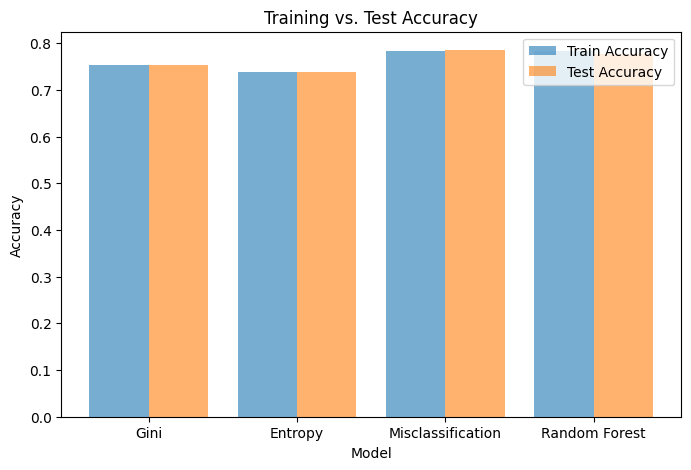

In [59]:
model_names = ["Gini", "Entropy", "Misclassification", "Random Forest"]
train_accuracies = [compute_accuracy(trees[name], X_train, y_train, X_test, y_test)[0] for name in model_names if name in trees]
test_accuracies = [compute_accuracy(trees[name], X_train, y_train, X_test, y_test)[1] for name in model_names if name in trees]

rf_train_acc, rf_test_acc, _, _, _ = compute_accuracy(rf, X_train, y_train, X_test, y_test)
train_accuracies.append(rf_train_acc)
test_accuracies.append(rf_test_acc)

plt.figure(figsize=(8, 5))
bar_width = 0.4
x = range(len(model_names))

plt.bar(x, train_accuracies, width=bar_width, alpha=0.6, label="Train Accuracy")
plt.bar([p + bar_width for p in x], test_accuracies, width=bar_width, alpha=0.6, label="Test Accuracy")

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Training vs. Test Accuracy")
plt.xticks([p + bar_width / 2 for p in x], model_names)
plt.legend()
plt.show()


In [60]:
class RandomForestV2:
    def __init__(self, n_trees=10, max_depth=None, min_impurity_decrease=0.0, max_features=None, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_subsets = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        num_features = X.shape[1]
        self.trees = []
        self.feature_subsets = []

        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth, min_impurity_decrease=self.min_impurity_decrease)

            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[bootstrap_indices], y[bootstrap_indices]

            if self.max_features is not None:
                feature_indices = np.random.choice(num_features, self.max_features, replace=False)
            else:
                feature_indices = np.arange(num_features)

            self.feature_subsets.append(feature_indices)
            X_subset = X_sample[:, feature_indices]
            
            tree.fit(X_subset, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        for tree, features in zip(self.trees, self.feature_subsets):
            X_subset = X[:, features]
            predictions.append(tree.predict(X_subset))

        predictions = np.array(predictions)
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

def evaluate_random_forest_versions():
    rf_versions = {
        "Original RF": RandomForest(n_trees=10, max_depth=5, random_state=42),
        "Deeper RF": RandomForest(n_trees=10, max_depth=6, random_state=42),
        "Deeper RF 2": RandomForest(n_trees=10, max_depth=7, random_state=42),
        "Larger RF": RandomForest(n_trees=50, max_depth=5, random_state=42),
        "Feature-Subset RF": RandomForestV2(n_trees=10, max_depth=5, max_features=5, random_state=42)
    }

    print("\nComparing Random Forest Variants:\n")
    for name, model in rf_versions.items():
        model.fit(X_train, y_train)
        train_acc, test_acc, gap, train_loss, test_loss = compute_accuracy(model, X_train, y_train, X_test, y_test)
        print(f"{name} - Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Overfitting Gap: {gap:.4f}, Training 0-1 Loss: {train_loss:.4f}, Test 0-1 Loss: {test_loss:.4f}")


evaluate_random_forest_versions()



Comparing Random Forest Variants:

Original RF - Training Accuracy: 0.7829, Test Accuracy: 0.7760, Overfitting Gap: 0.0069, Training 0-1 Loss: 0.2171, Test 0-1 Loss: 0.2240
Deeper RF - Training Accuracy: 0.7920, Test Accuracy: 0.7848, Overfitting Gap: 0.0072, Training 0-1 Loss: 0.2080, Test 0-1 Loss: 0.2152
Deeper RF 2 - Training Accuracy: 0.8189, Test Accuracy: 0.8114, Overfitting Gap: 0.0074, Training 0-1 Loss: 0.1811, Test 0-1 Loss: 0.1886
Larger RF - Training Accuracy: 0.7774, Test Accuracy: 0.7688, Overfitting Gap: 0.0086, Training 0-1 Loss: 0.2226, Test 0-1 Loss: 0.2312
Feature-Subset RF - Training Accuracy: 0.7871, Test Accuracy: 0.7870, Overfitting Gap: 0.0002, Training 0-1 Loss: 0.2129, Test 0-1 Loss: 0.2130


In [64]:
# Sample a smaller subset for tuning
X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)

In [67]:
def tune_decision_tree(X_sub, y_sub):
    param_grid = {
        "max_depth": [3, 5, 7, 10],
        "min_impurity_decrease": [0.0, 0.01, 0.02, 0.05]
    }

    grid_search = GridSearchCV(DecisionTree(), param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_sub, y_sub)
    best_grid_tree = grid_search.best_estimator_
    print(f"Best Grid Search Decision Tree: {grid_search.best_params_}, Accuracy: {grid_search.best_score_:.4f}")

    random_search = RandomizedSearchCV(DecisionTree(), param_grid, n_iter=10, cv=3, scoring="accuracy", random_state=42, n_jobs=-1)
    random_search.fit(X_sub, y_sub)
    best_random_tree = random_search.best_estimator_
    print(f"Best Random Search Decision Tree: {random_search.best_params_}, Accuracy: {random_search.best_score_:.4f}")

    return best_grid_tree, best_random_tree, grid_search.best_params_, random_search.best_params_

print("\nTuning Decision Tree:")
_, _, best_grid_tree_params, best_random_tree_params = tune_decision_tree(X_small, y_small)


Tuning Decision Tree:
Best Grid Search Decision Tree: {'max_depth': 10, 'min_impurity_decrease': 0.0}, Accuracy: 0.9223
Best Random Search Decision Tree: {'min_impurity_decrease': 0.01, 'max_depth': 10}, Accuracy: 0.9204


In [69]:
def tune_random_forest(X_sub, y_sub):
    param_grid = {
        "n_trees": [10, 20, 50],
        "max_depth": [5, 7, 10]
    }

    grid_search = GridSearchCV(RandomForest(), param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_sub, y_sub)
    best_grid_rf = grid_search.best_estimator_
    print(f"Best Grid Search Random Forest: {grid_search.best_params_}, Accuracy: {grid_search.best_score_:.4f}")

    random_search = RandomizedSearchCV(RandomForest(), param_grid, n_iter=4, cv=3, scoring="accuracy", random_state=42, n_jobs=-1)
    random_search.fit(X_sub, y_sub)
    best_random_rf = random_search.best_estimator_
    print(f"Best Random Search Random Forest: {random_search.best_params_}, Accuracy: {random_search.best_score_:.4f}")

    return best_grid_rf, best_random_rf, grid_search.best_params_, random_search.best_params_

print("\nTuning Random Forest:")
_, _, best_grid_rf_params, best_random_rf_params = tune_random_forest(X_small, y_small)


Tuning Random Forest:
Best Grid Search Random Forest: {'max_depth': 10, 'n_trees': 50}, Accuracy: 0.9493
Best Random Search Random Forest: {'n_trees': 20, 'max_depth': 10}, Accuracy: 0.9600


In [70]:
# Retrain final models on full training set using best params
final_grid_tree = DecisionTree(**best_grid_tree.get_params()).fit(X_train, y_train)
final_random_tree = DecisionTree(**best_random_tree.get_params()).fit(X_train, y_train)


In [75]:
final_grid_rf = RandomForest(**best_grid_rf_params).fit(X_train, y_train)
final_random_rf = RandomForest(**best_random_rf_params).fit(X_train, y_train)


In [76]:
def analyze_overfitting(models, X_train, y_train, X_test, y_test):
    print("\nOverfitting & Underfitting Analysis:\n")
    print(f"{'Model':<30} {'Training Accuracy':<20} {'Test Accuracy':<20} {'Overfitting Gap':<20}")
    print("=" * 90)

    for name, model in models.items():
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_acc = np.mean(y_train_pred == y_train)
        test_acc = np.mean(y_test_pred == y_test)
        gap = train_acc - test_acc

        print(f"{name:<30} {train_acc:<20.4f} {test_acc:<20.4f} {gap:<20.4f}")

models_to_analyze = {
    "Gini Tree": trees["Gini"],
    "Entropy Tree": trees["Entropy"],
    "Misclassification Tree": trees["Misclassification"],
    "Original Random Forest": rf,
    "Best Grid Tree": final_grid_tree,
    "Best Random Tree": final_random_tree,
    "Best Grid RF": final_random_rf,
    "Best Random RF": final_random_rf,
}

analyze_overfitting(models_to_analyze, X_train, y_train, X_test, y_test)


Overfitting & Underfitting Analysis:

Model                          Training Accuracy    Test Accuracy        Overfitting Gap     
Gini Tree                      0.7531               0.7536               -0.0005             
Entropy Tree                   0.7383               0.7384               -0.0001             
Misclassification Tree         0.7837               0.7852               -0.0015             
Original Random Forest         0.7829               0.7760               0.0069              
Best Grid Tree                 0.9398               0.9388               0.0010              
Best Random Tree               0.9354               0.9356               -0.0002             
Best Grid RF                   0.9448               0.9438               0.0010              
Best Random RF                 0.9448               0.9438               0.0010              


In [77]:
class DecisionTreeWithPruning(DecisionTree):
    def __init__(self, criterion="entropy", max_depth=None, min_impurity_decrease=0.0):
        super().__init__(criterion=criterion, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)

    def prune(self, X_val, y_val):
        """
        Perform reduced error post-pruning using a validation set.
        """

        def _prune_node(node, X_val_sub, y_val_sub):
            if node is None or node.is_leaf():
                return

            if node.left:
                left_mask = self._make_split_mask(X_val_sub[:, node.feature], node.threshold)
                _prune_node(node.left, X_val_sub[left_mask], y_val_sub[left_mask])

            if node.right:
                right_mask = ~self._make_split_mask(X_val_sub[:, node.feature], node.threshold)
                _prune_node(node.right, X_val_sub[right_mask], y_val_sub[right_mask])
            
            accuracy_before = np.mean(self.predict(X_val_sub) == y_val_sub)
            
            original_left, original_right = node.left, node.right
            node.left = node.right = None
            node.value = Counter(y_val_sub).most_common(1)[0][0]
            
            accuracy_after = np.mean(self.predict(X_val_sub) == y_val_sub)
        
            if accuracy_after < accuracy_before:
                node.left, node.right = original_left, original_right
                node.value = None

        _prune_node(self.root, X_val, y_val)

    def _make_split_mask(self, feature_column, threshold):
        
        if self._is_numeric(feature_column):
            return feature_column.astype(float) <= float(threshold)
        else:
            return feature_column == threshold


Before Pruning - Training Accuracy: 0.9567, Validation Accuracy: 0.9520
Total Nodes Before Pruning: 245

Entropy Tree Before Pruning:


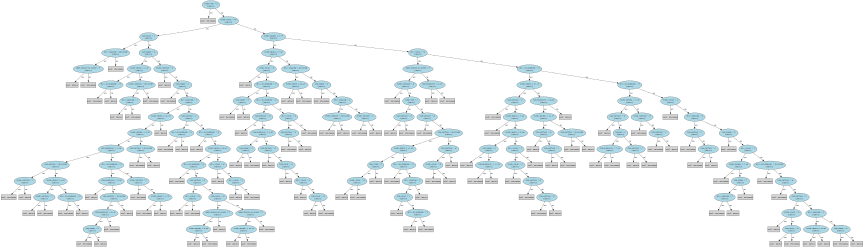

Visualization saved as: C:/Users/aknur/Downloads/entropy_tree_before_pruning.png

After Pruning - Training Accuracy: 0.9554, Validation Accuracy: 0.9522
Total Nodes After Pruning: 205

Entropy Tree After Pruning:


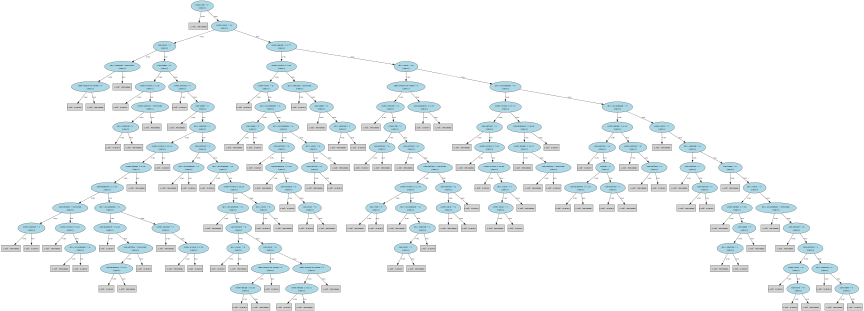

Visualization saved as: C:/Users/aknur/Downloads/entropy_tree_after_pruning.png


In [81]:
class VisualDecisionTree(DecisionTreeWithPruning):
    def __init__(self, criterion="entropy", max_depth=15, min_impurity_decrease=0.0, feature_names=None):
        super().__init__(criterion=criterion, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
        self.feature_names = feature_names 

    def export_graphviz(self, node=None, graph=None, parent=None, edge_label=""):
        if graph is None:
            graph = Digraph()
            graph.attr(size="12,12")  
        if node is None:
            node = self.root  

        node_id = str(id(node))

        if node.is_leaf():
            label = f"Leaf: {'Poisonous' if node.value == 1 else 'Edible'}"
            graph.node(node_id, label, shape="box", style="filled", fillcolor="lightgray")
        else:
            feature_name = self.feature_names[node.feature] if self.feature_names else f"Feature {node.feature}"
            if isinstance(node.threshold, (int, float)):
                label = f"{feature_name} ≤ {node.threshold:.2f}\n(Split)"
            else:
                label = f"{feature_name} = {node.threshold}\n(Split)"
            graph.node(node_id, label, shape="ellipse", style="filled", fillcolor="lightblue")

        if parent is not None:
            graph.edge(parent, node_id, label=edge_label)

        if node.left:
            self.export_graphviz(node.left, graph, node_id, "Yes")
        if node.right:
            self.export_graphviz(node.right, graph, node_id, "No")

        return graph
   
    def count_nodes(self, node=None):
        if node is None:
            node = self.root
        if node is None or node.is_leaf():
            return 1
        return 1 + self.count_nodes(node.left) + self.count_nodes(node.right)

def display_tree(tree, title="Decision Tree Visualization", filename="decision_tree"):
    print(f"\n{title}:")
    graph = tree.export_graphviz()
    png_path = f"C:/Users/aknur/Downloads/{filename}"
    graph.render(png_path, format="png", cleanup=True) 
    display(graph)
    print(f"Visualization saved as: {png_path}.png")

feature_names = list(df.drop(columns=['class']).columns)
entropy_tree_before = VisualDecisionTree(criterion="entropy", max_depth=15, feature_names=feature_names)
entropy_tree_before.fit(X_train_new, y_train_new)

train_acc_before = np.mean(entropy_tree_before.predict(X_train_new) == y_train_new)
val_acc_before = np.mean(entropy_tree_before.predict(X_val) == y_val)
node_count_before = entropy_tree_before.count_nodes()

print(f"Before Pruning - Training Accuracy: {train_acc_before:.4f}, Validation Accuracy: {val_acc_before:.4f}")
print(f"Total Nodes Before Pruning: {node_count_before}")
display_tree(entropy_tree_before, title="Entropy Tree Before Pruning", filename="entropy_tree_before_pruning")

entropy_tree_before.prune(X_val, y_val)

train_acc_after = np.mean(entropy_tree_before.predict(X_train_new) == y_train_new)
val_acc_after = np.mean(entropy_tree_before.predict(X_val) == y_val)
node_count_after = entropy_tree_before.count_nodes()

print(f"\nAfter Pruning - Training Accuracy: {train_acc_after:.4f}, Validation Accuracy: {val_acc_after:.4f}")
print(f"Total Nodes After Pruning: {node_count_after}")
display_tree(entropy_tree_before, title="Entropy Tree After Pruning", filename="entropy_tree_after_pruning")
